# Example Analysis with TSCPC GRIP in Python
The data here is TCSPC of acrylodan in a binary solvent of acetonitrile and methanol. The data is arranged from 100% methanol to 100% acetonitrile in 10% increments.

First, import the python file along with other necessary python libraries.

In [42]:
from tcspc_corrected_workflow import *

import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Import Data
This data is acrylodan in a binary solvent from 100% methanol (ace000.txt) to 100% acetonitrile (ace100.txt) in 10% increments. There are 11 different concentrations. The TCSPC TAC is 50 ns with 4096 resolution. Therefore, the binning is 0.0122216 ns. The first column is the time in ns.

In [160]:
# Find your data files
data_pattern = './data/*.txt'
data_files = sorted(glob.glob(data_pattern))

# Find your IRF files
irf_pattern = './irf/*.txt'
irf_files = sorted(glob.glob(irf_pattern))

print(f"Found {len(data_files)} data files")
print(f"Found {len(irf_files)} IRF files")

Found 11 data files
Found 1 IRF files


## Inspect the Data

In [44]:
# Check that data and IRF have same time axis
from tcspc_corrected_workflow import DataLoader

loader = DataLoader()

# Load first data file
data_dict = loader.load_generic_ascii(data_files[0])
data_time = data_dict['time']

# Load first IRF file
irf_dict = loader.load_generic_ascii(irf_files[0])
irf_time = irf_dict['time']

# Verify
assert len(data_time) == len(irf_time), "Data and IRF must have same length!"
assert np.allclose(data_time, irf_time), "Data and IRF must have same time axis!"

print("✓ Files are compatible")

✓ Files are compatible


## Run the automated complete analysis
A few parameters can be adjusted here. It's likely that adjustments will need to be iterated to get the optimal fits.
* The data can be truncated by time or index.
* The initial guess of lag (time shift of IRF) can be given as a single value for all data or for each data file.
* The analysis results can be displayed and saved.

There is more manual control available. A manual analysis demonstration is given further below.

TCSPC ANALYSIS WITH TRUNCATION AND LAG CONTROL

1. Loading Data and IRFs...
   Data: 4096 time points, 11 traces
   IRFs: 1 available
   Time range: 0.000 to 50.047 ns

1.5. Visualizing Data for Truncation Selection...


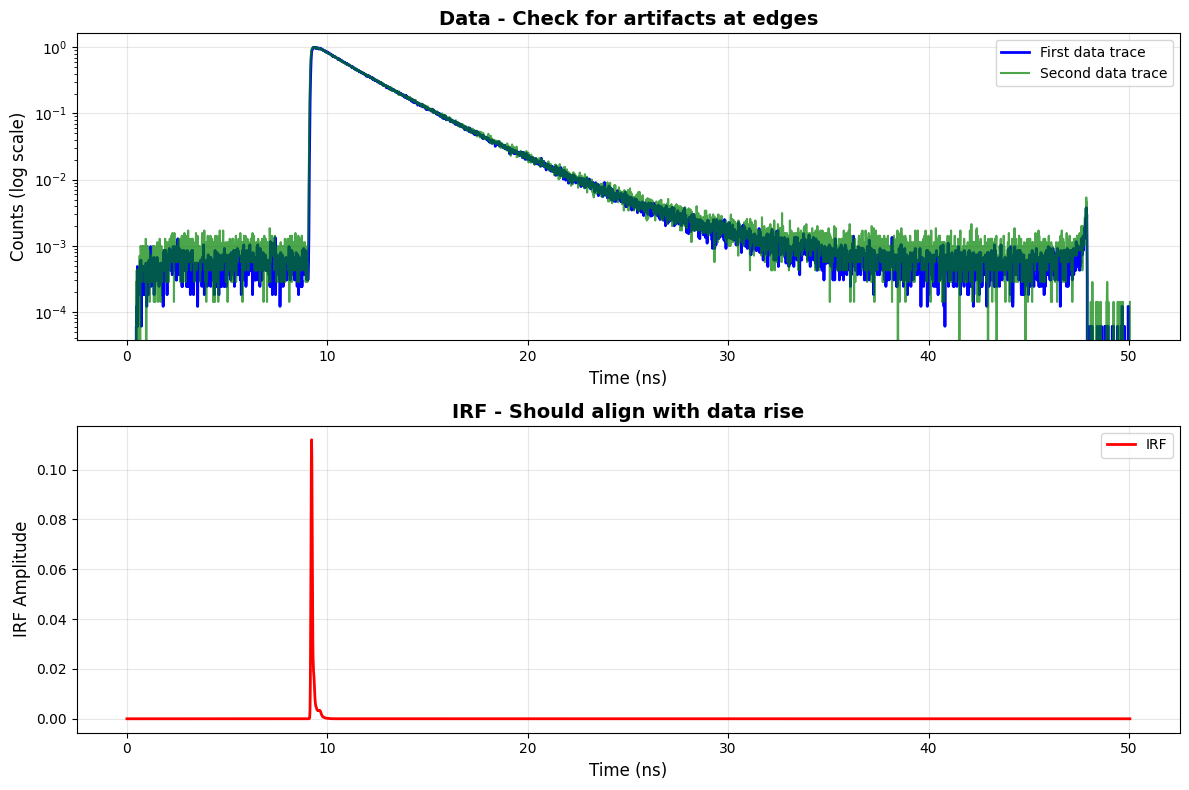


Inspect the plots above to choose truncation points.
Look for:
  - Electronic artifacts at early times
  - Low count/noisy regions at late times
  - IRF position relative to data

1.5. Truncating Data and IRFs...
Truncation applied:
  Original: 4096 points from 0.000 to 50.047 ns
  Truncated: 3723 points from 2.004 to 47.493 ns
  Removed: 164 points at start, 209 points at end

2. Preprocessing Data...
   Data preprocessing complete

3. Creating Lifetime Grid...
   Grid: 49 points from 0.010 to 10.000 ns

4. Finding Best IRF and Lag for Each Trace...
   Using initial lag estimate: 0.9140 ns for all traces

Testing 1 IRF(s) against 11 data trace(s)...
  Using initial lag estimates: mean = 0.9140 ns
  Testing IRF 1/1...
Calculating lags for 11 traces...
  (Estimated time: 0 minutes)

IRF Selection Results:
  Trace 0: IRF 0, χ² = 0.0146, lag = -0.0860 ns
  Trace 1: IRF 0, χ² = 0.0147, lag = 0.1140 ns
  Trace 2: IRF 0, χ² = 0.0147, lag = 0.1140 ns
  Trace 3: IRF 0, χ² = 0.0149, lag = -0.0

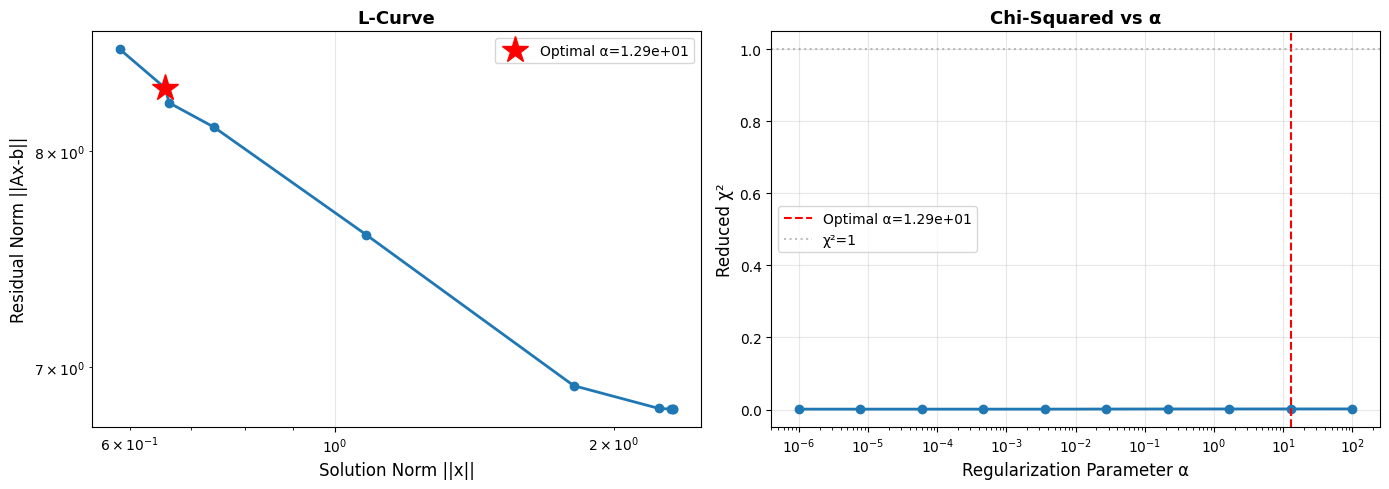

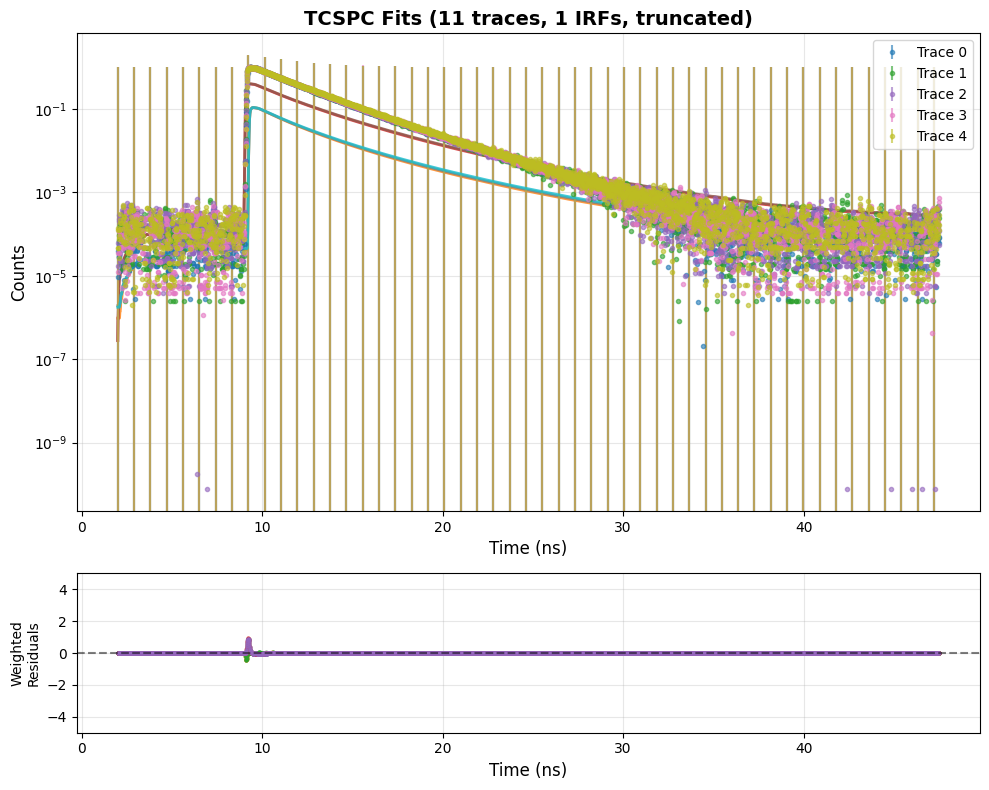

   Creating lifetime distribution plot...


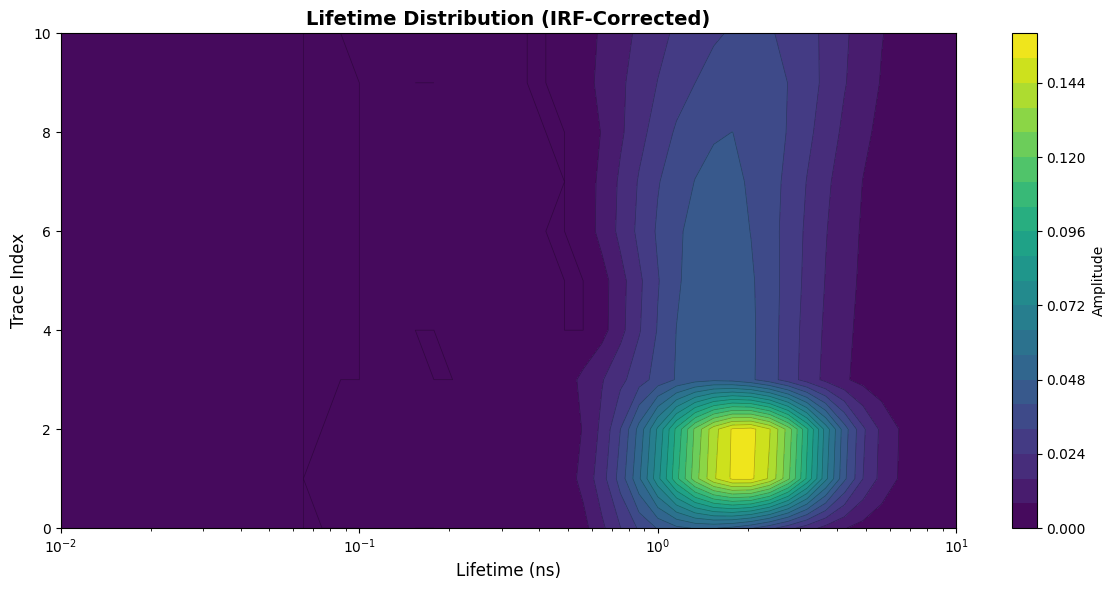

   Creating convergence plot...


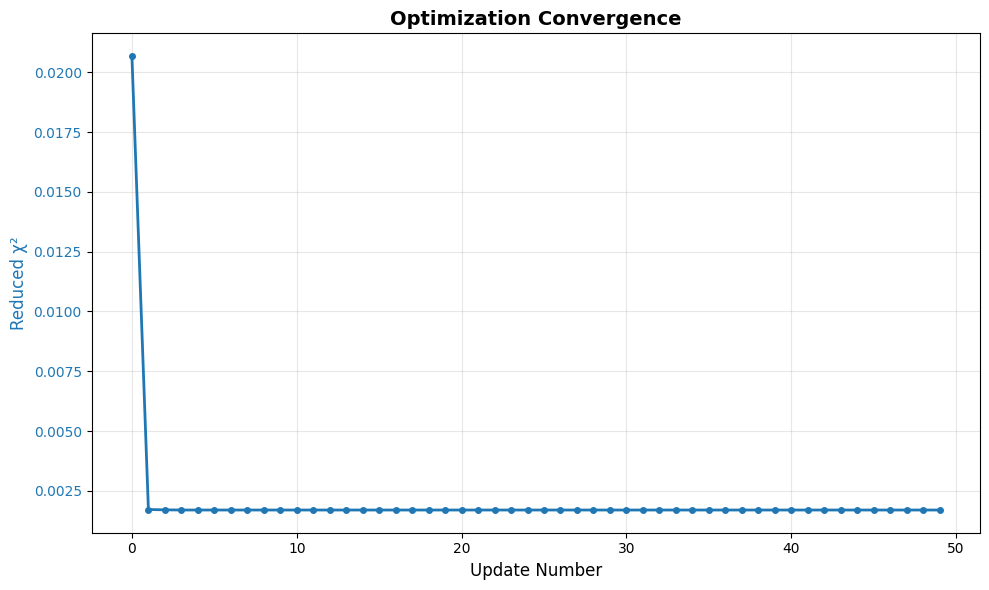

   Creating residual analysis plot...


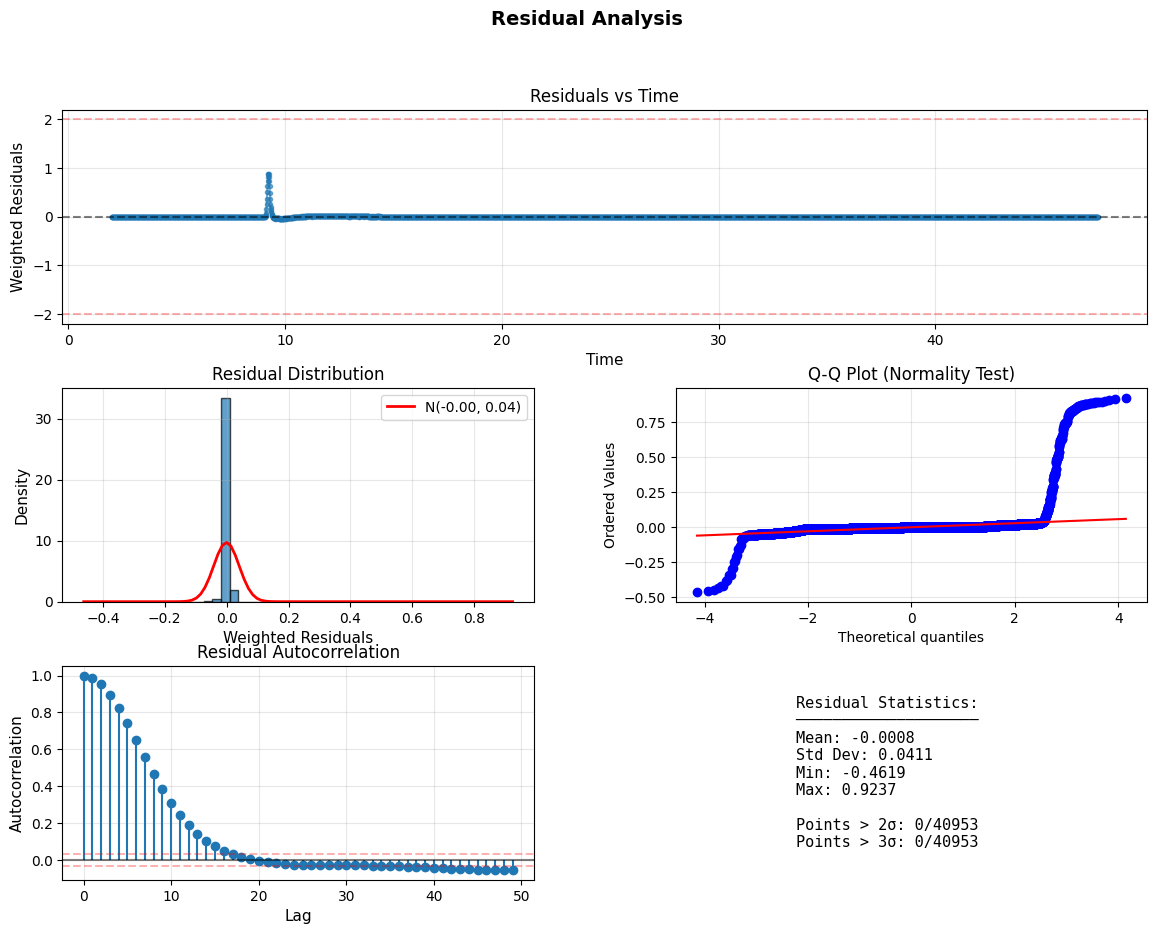


   All plots displayed. Close plot windows to continue or use plt.show() to keep them open.

ANALYSIS RESULTS

Truncation:
  Original: 4096 points
  Used: 3723 points (90.9%)

Lag Summary:
  Mean: -0.0496 ns
  Std: 0.0771 ns
  Range: [-0.0860, 0.1140] ns

Quality Metrics:
  Final reduced χ²: 0.0017
  Effective free parameters: 280.5
  ✓ Excellent fit

Lifetime Analysis (first 11 traces):

--- Trace 0 (IRF 0, lag -0.0860 ns) ---
Significant lifetimes:
  τ = 0.562 ns, amplitude = 0.0055
  τ = 0.649 ns, amplitude = 0.0144
  τ = 0.750 ns, amplitude = 0.0238
  τ = 0.866 ns, amplitude = 0.0332
  τ = 1.000 ns, amplitude = 0.0407
  τ = 1.155 ns, amplitude = 0.0460
  τ = 1.334 ns, amplitude = 0.0486
  τ = 1.540 ns, amplitude = 0.0485
  τ = 1.778 ns, amplitude = 0.0458
  τ = 2.054 ns, amplitude = 0.0409
  τ = 2.371 ns, amplitude = 0.0343
  τ = 2.738 ns, amplitude = 0.0268
  τ = 3.162 ns, amplitude = 0.0195
  τ = 3.652 ns, amplitude = 0.0132
  τ = 4.217 ns, amplitude = 0.0084
  τ = 4.870 ns, amp

In [45]:
from tcspc_corrected_workflow import complete_tcspc_workflow_with_irf

# Run complete workflow
results = complete_tcspc_workflow_with_irf(
    data_files,
    irf_files,
    truncate_start=2.00,      # Start at 1.0 ns
    truncate_end=47.5,       # End at 24.0 ns
    # OR use indices:
    #truncate_start_idx=20,   # Skip first 20 points
    #truncate_end_idx=-30     # Skip last 30 points
    initial_lags=0.914,        # Single value for all traces
    # OR per-trace array:
    #initial_lags=[-0.5, -0.3, -0.6]  # Different for each trace
    show_plots=True,   # Display as created (default)
    save_plots=False# Also save to files (default)
)

plt.show()

# Manual Analysis
## Overview
The process for manually running the analysis follows these steps.
1. Load data.
  * For now, text files with columns `time` and `counts` is tested.
  * Results may be improved by normalizing the data to a maximum of 1. IRFs should also be normalized either maximum of 1 or integration of 1.
2. Truncate the data and irf.
3. Preprocess the data.
4. Create a lifetime grid.
5. Select the best IRF for each data trace if multiple IRFs are provided, and calculate the optimal lags.
6. Build a design matrix with IRF convolution.
7. Build the regularization matrix.
8. Find the optimal $\alpha$ from the L-curve.
9. Regularized IPG fit.
10. Visualize the results.

In [134]:
# 1. LOAD DATA
loader = DataLoader()
time_axis = None
# Find your data files
data_pattern = "/content/data/*.txt"
data_files = sorted(glob.glob(data_pattern))

# Find your IRF files
irf_pattern = '/content/irf/*.txt'
irf_files = sorted(glob.glob(irf_pattern))

# Load data files
all_data = []
for i, filename in enumerate(data_files):
  #print(f"Loading {filename}...")
  data_dict = loader.load_generic_ascii(filename, skip_header=0)
  if i == 0 and time_axis is None:
    time = data_dict['time']
  all_data.append(data_dict['data'].flatten())

data_matrix = np.column_stack(all_data)

# Load IRF files
all_irfs = []
for filename in irf_files:
  irf_dict = loader.load_generic_ascii(filename, skip_header=0)
  all_irfs.append(irf_dict['data'].flatten())

irf_matrix = np.column_stack(all_irfs)

# Use provided time axis if given
if time_axis is not None:
  time = time_axis

n_times_orig = len(time)
n_traces = data_matrix.shape[1]
n_irfs = irf_matrix.shape[1]

print(f"   Data: {n_times_orig} time points, {n_traces} traces")
print(f"   IRFs: {n_irfs} available")
print(f"   Time range: {time[0]:.3f} to {time[-1]:.3f} ns")

   Data: 4096 time points, 11 traces
   IRFs: 1 available
   Time range: 0.000 to 50.047 ns


### 1a. Visualize the Data

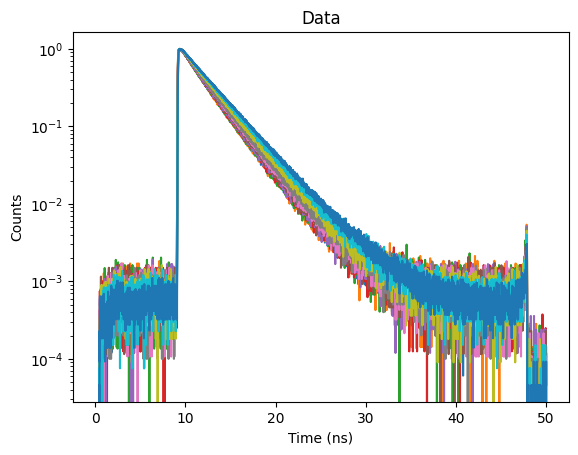

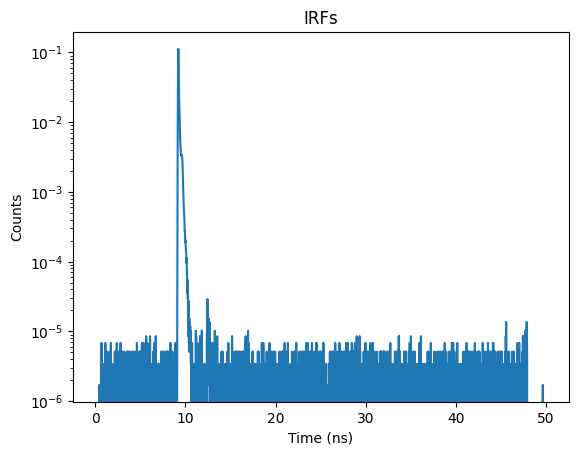

In [135]:
#plot the data
for i in range(data_matrix.shape[1]):
  plt.semilogy(time, data_matrix[:,i])

plt.xlabel('Time (ns)')
plt.ylabel('Counts')
plt.title('Data')
plt.show()

#plot the IRFs
for i in range(irf_matrix.shape[1]):
  plt.semilogy(time, irf_matrix[:,i])

plt.xlabel('Time (ns)')
plt.ylabel('Counts')
plt.title('IRFs')
plt.show()

### 2. Truncate the Data and IRF



2. Visualizing Data for Truncation Selection...


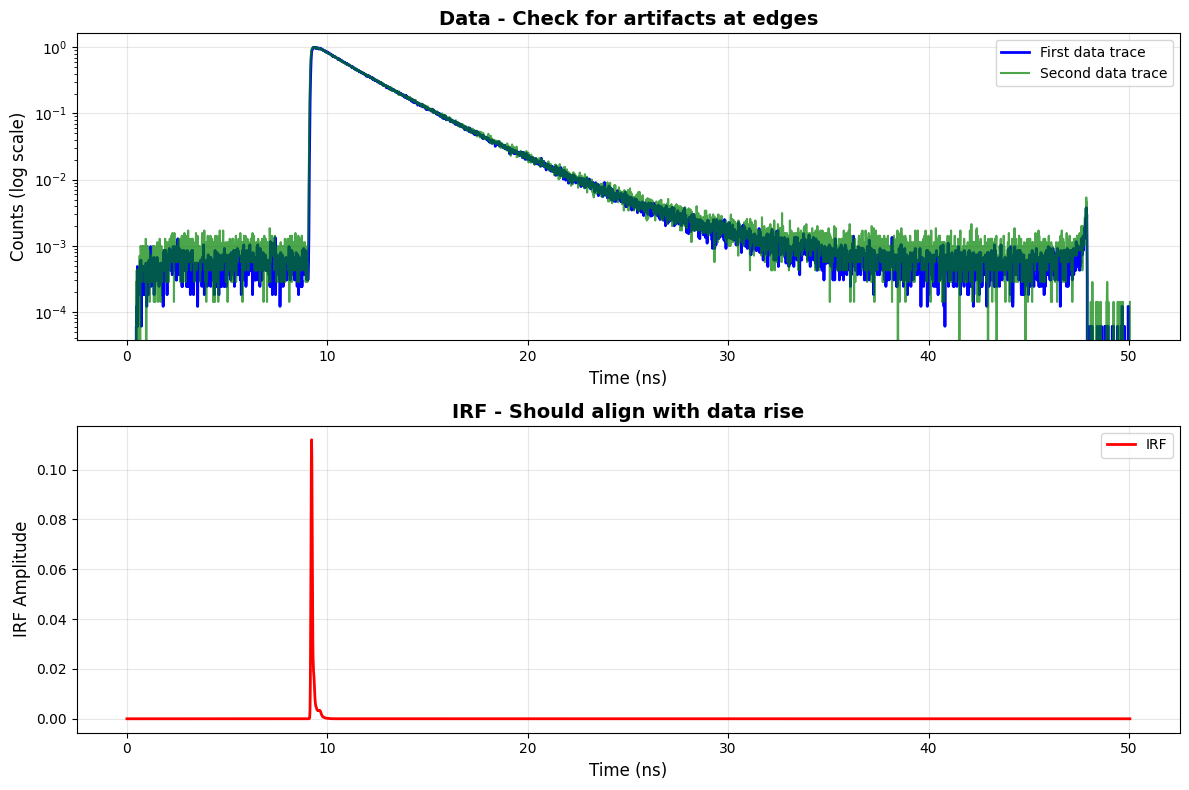


Inspect the plots above to choose truncation points.
Look for:
  - Electronic artifacts at early times
  - Low count/noisy regions at late times
  - IRF position relative to data

2. Truncating Data and IRFs...
Truncation applied:
  Original: 4096 points from 0.000 to 50.047 ns
  Truncated: 3723 points from 2.004 to 47.493 ns
  Removed: 164 points at start, 209 points at end


In [136]:
# Show visualization if requested
show_truncation_plot = True
truncate_start=2.00,      # Start ns
truncate_end=47.5,       # End ns
truncate_start_idx=None#np.where(time==truncate_start)   # Skip first points
truncate_end_idx=None#np.where(time==truncate_end) #Skip last points

if show_truncation_plot:
  print("\n2. Visualizing Data for Truncation Selection...")
  interactive_truncation(time, data_matrix, irf_matrix)

# Apply truncation if requested
if any([truncate_start, truncate_end, truncate_start_idx, truncate_end_idx]):
  print("\n2. Truncating Data and IRFs...")
  time, data_matrix, irf_matrix = truncate_tcspc_data(
      time, data_matrix, irf_matrix,
      start_time=truncate_start,
      end_time=truncate_end,
      start_index=truncate_start_idx,
      end_index=truncate_end_idx
  )
else:
  print("\n2. No truncation requested (using full time range)")

n_times = len(time)
data_final = data_matrix

#### Check the truncation
Plot the data and IRFs to see that truncation is what you want.

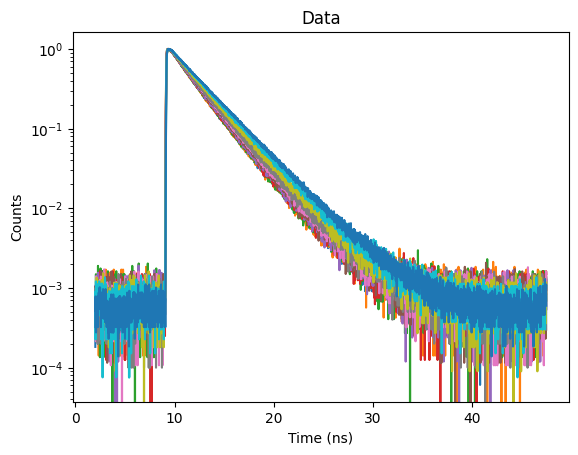

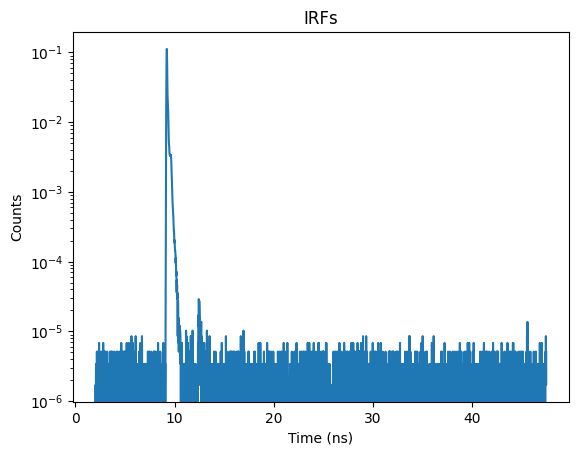

In [137]:
#plot the data
for i in range(data_final.shape[1]):
  plt.semilogy(time, data_final[:,i])

plt.xlabel('Time (ns)')
plt.ylabel('Counts')
plt.title('Data')
plt.show()

#plot the IRFs
for i in range(irf_matrix.shape[1]):
  plt.semilogy(time, irf_matrix[:,i])

plt.xlabel('Time (ns)')
plt.ylabel('Counts')
plt.title('IRFs')
plt.show()

### 3. Preprocess Data (Optional)


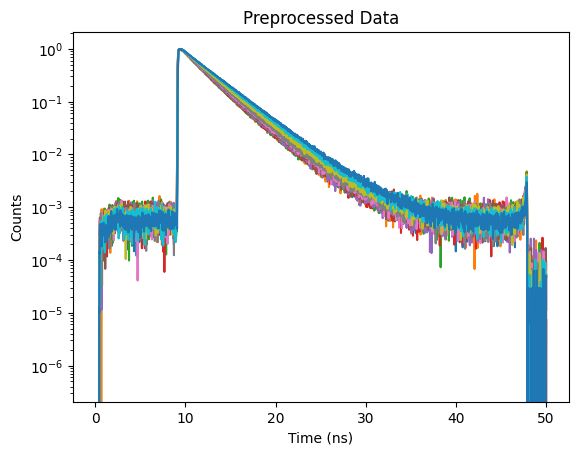

In [39]:
#PREPROCESS
from tcspc_analysis import DataPreprocessor

preprocessor = DataPreprocessor()

# Clean data
data_clean = preprocessor.remove_cosmic_rays(data_matrix, threshold=5.0)
data_corrected = preprocessor.baseline_correction(data_clean, method='tail',
                                                  tail_points=50)
# Smooth if necessary
data_final = preprocessor.smooth_data(data_corrected, method='savgol',
                                         window=5, order=2)

#plot the data
for i in range(data_final.shape[1]):
  plt.semilogy(time, data_final[:,i])

plt.xlabel('Time (ns)')
plt.ylabel('Counts')
plt.title('Preprocessed Data')
plt.show()

### 4. Create a Grid
There is control here to make the lifetime grid span the range you want and to increase the resolution of the grid.

In [138]:
# STEP 4: CREATE INITIAL GRID
grid_gen = GridGenerator()
grid = grid_gen.make_log_grid(0.01, 10, 24) #start, stop, num points per decade

n_grid = len(grid)
print(f"   Grid: {n_grid} points from {grid[0]:.3f} to {grid[-1]:.3f} ns")

   Grid: 73 points from 0.010 to 10.000 ns


### 5. Calculate Optimal IRF and Lag Parameters

In [139]:
# 5. CALCULATE OPTIMAL LAGS
initial_lags = 0.914
#initial_lags = [-0.5, -0.3, -0.6]  # Different for each trace

if initial_lags is not None:
  if np.isscalar(initial_lags):
    print(f"   Using initial lag estimate: {initial_lags:.4f} ns for all traces")
  else:
    print(f"   Using per-trace lag estimates: mean = {np.mean(initial_lags):.4f} ns")

irf_selector = IRFSelectorCorrected()
irf_results = irf_selector.find_best_irf(
    data_final,
    irf_matrix,
    grid,
    initial_lags=initial_lags,
    lag_divisions=10
    )

best_irf_indices = irf_results['best_irf_indices']
best_lags = irf_results['best_lags']

print(f"\n   IRF selection complete!")
print(f"   Lag range: {np.min(best_lags):.4f} to {np.max(best_lags):.4f} ns")
print(f"   Mean lag: {np.mean(best_lags):.4f} ns")

   Using initial lag estimate: 0.9140 ns for all traces

Testing 1 IRF(s) against 11 data trace(s)...
  Using initial lag estimates: mean = 0.9140 ns
  Testing IRF 1/1...
Calculating lags for 11 traces...
  (Estimated time: 0 minutes)

IRF Selection Results:
  Trace 0: IRF 0, χ² = 0.0146, lag = -0.0860 ns
  Trace 1: IRF 0, χ² = 0.0147, lag = 0.1140 ns
  Trace 2: IRF 0, χ² = 0.0147, lag = 0.1140 ns
  Trace 3: IRF 0, χ² = 0.0149, lag = -0.0860 ns
  Trace 4: IRF 0, χ² = 0.0150, lag = -0.0860 ns
  Trace 5: IRF 0, χ² = 0.0157, lag = -0.0860 ns
  Trace 6: IRF 0, χ² = 0.0159, lag = -0.0860 ns
  Trace 7: IRF 0, χ² = 0.0159, lag = -0.0860 ns
  Trace 8: IRF 0, χ² = 0.0175, lag = -0.0860 ns
  Trace 9: IRF 0, χ² = 0.0185, lag = -0.0860 ns
  ... (showing first 10 of 11 traces)

IRF Usage Summary:
  IRF 0: used by 11 trace(s)

   IRF selection complete!
   Lag range: -0.0860 to 0.1140 ns
   Mean lag: -0.0496 ns


### 6. Build a Design Matrix

In [152]:
# STEP 6: CREATE REGULARIZATION MATRIX

dx = time[1] - time[0] if len(time) > 1 else 1.0
n_params = n_grid + 2  # grid + scattering + baseline
design_matrix_3d = np.zeros((n_times, n_params, n_traces))
std_matrix = np.sqrt(np.maximum(data_final, 1))

for trace_idx in range(n_traces):
  if trace_idx % max(1, n_traces // 10) == 0:
    print(f"   Convolving trace {trace_idx+1}/{n_traces}...")

  # Get the BEST IRF for THIS trace (using mapping)
  best_irf_idx = best_irf_indices[trace_idx]
  irf = irf_matrix[:, best_irf_idx]
  lag = best_lags[trace_idx]

  # Shift IRF by optimal lag
  x_shifted = np.arange(len(irf)) * dx + lag
  irf_shifted = np.interp(x_shifted, np.arange(len(irf)) * dx, irf,
                         left=0, right=0)
  # Normalize IRF
  irf_sum = np.sum(irf_shifted)
  if irf_sum > 0:
    irf_shifted = irf_shifted / irf_sum

  # Build exponential basis functions
  basis_matrix = np.zeros((n_times, n_grid))
  for i, tau in enumerate(grid):
    basis_matrix[:, i] = np.exp(-time / tau)

  # Convolve each basis function with IRF
  design_conv = np.zeros((n_times, n_grid))
  for i in range(n_grid):
    basis_func = basis_matrix[:, i]
    convolved = np.convolve(basis_func, irf_shifted, mode='full')[:n_times]
    design_conv[:, i] = convolved

  # Add scattering (IRF shape)
  scattering = irf_shifted[:n_times] if len(irf_shifted) >= n_times else np.pad(irf_shifted, (0, n_times - len(irf_shifted)))

  # Add baseline
  baseline = np.ones(n_times)

  # Combine: [convolved exponentials | scattering | baseline]
  design_matrix_3d[:, :n_grid, trace_idx] = design_conv
  design_matrix_3d[:, n_grid, trace_idx] = scattering
  design_matrix_3d[:, n_grid+1, trace_idx] = baseline

  # Normalize by standard deviation
  design_matrix_3d[:, :, trace_idx] /= std_matrix[:, trace_idx, np.newaxis]

print(f"   Design matrix complete: {design_matrix_3d.shape}")

   Convolving trace 1/11...
   Convolving trace 2/11...
   Convolving trace 3/11...
   Convolving trace 4/11...
   Convolving trace 5/11...
   Convolving trace 6/11...
   Convolving trace 7/11...
   Convolving trace 8/11...
   Convolving trace 9/11...
   Convolving trace 10/11...
   Convolving trace 11/11...
   Design matrix complete: (3723, 75, 11)


### 7. Create a Regularization Matrix

In [153]:
reg_matrix = RegularizationMatrix.make_reg_matrix_2nd_derivative(n_params)

### 8. Find $\alpha$ from L-curve
Depending on the $\chi^2$, the range of $\alpha$ values may need to be adjusted. More values can be searched, too.

L-curve analysis with 10 alpha values...
  Testing alpha = 1.00e-06 (1/10)
  Testing alpha = 7.74e-06 (2/10)
  Testing alpha = 5.99e-05 (3/10)
  Testing alpha = 4.64e-04 (4/10)
  Testing alpha = 3.59e-03 (5/10)
  Testing alpha = 2.78e-02 (6/10)
  Testing alpha = 2.15e-01 (7/10)
  Testing alpha = 1.67e+00 (8/10)
  Testing alpha = 1.29e+01 (9/10)
  Testing alpha = 1.00e+02 (10/10)
Optimal alpha from L-curve: 1.29e+01
   Optimal α: 1.29e+01


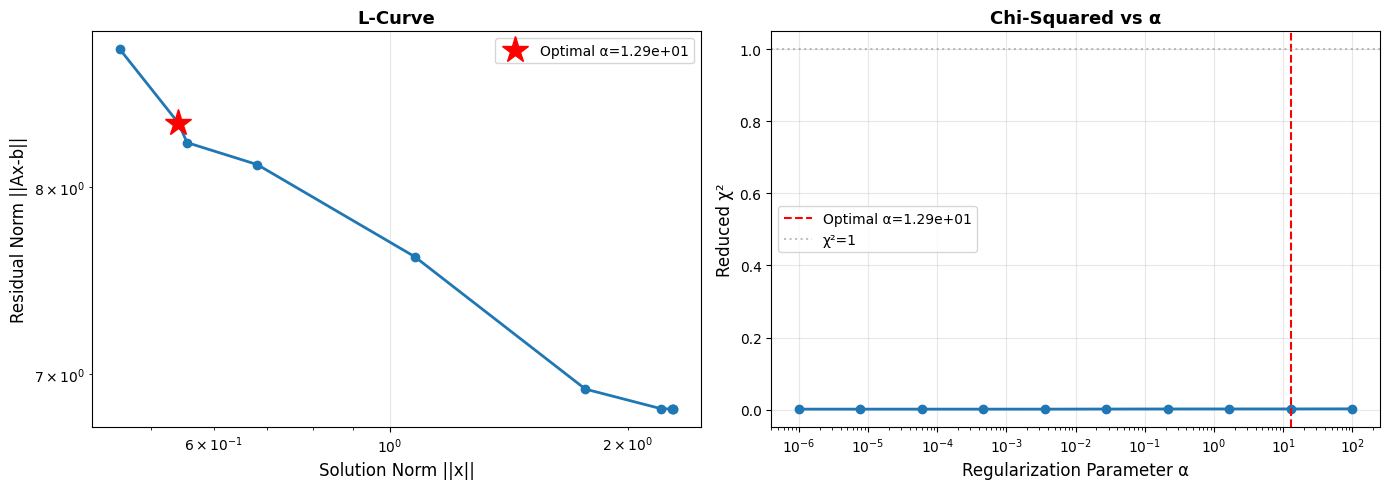

In [154]:
# STEP 7: FIND OPTIMAL REGULARIZATION PARAMETER
solver = IPGSolver()
adaptive_reg = AdaptiveRegularization(solver)

# Test range of alpha values
alphas = np.logspace(-6, 2, 10)

lcurve_results = adaptive_reg.lcurve_analysis(
    data_final, std_matrix, design_matrix_3d,
    reg_matrix, grid, alphas,
    n_iterations=500,
    tau=0.9,
    plot=True
    )

optimal_alpha = lcurve_results['optimal_alpha']
print(f"   Optimal α: {optimal_alpha:.2e}")

### 9. Fit Regularized IPG

In [155]:
# STEP 9: PERFORM REGULARIZED FIT
setup = solver.setup_gipg(
data_final, std_matrix, design_matrix_3d, reg_matrix, grid, optimal_alpha, normalize=True)

# Global fit
if n_traces == 1:
  params = solver.local_ipg(setup, n_iterations=5000, n_updates=50,
                            alpha=optimal_alpha, tau=0.9)
else:
  params = solver.global_ipg(setup, n_iterations=5000, n_updates=50,
                            alpha=optimal_alpha, tau=0.9)

params_matrix = params.reshape((n_params, n_traces), order='F')

print(f"   Fit complete!")
print(f"   Final χ²: {solver.chi_history[-1]:.4f}")

   Fit complete!
   Final χ²: 0.0017


In [156]:
# STEP 9: CALCULATE FITS AND RESIDUALS

print("\n9. Calculating Fits and Residuals...")

design_flat = setup['design_flat']
fits_flat = design_flat @ params
fits_matrix = fits_flat.reshape((n_times, n_traces), order='F')

residuals_flat = (setup['data_flat'] - fits_flat) / setup['std_flat']
residuals_matrix = residuals_flat.reshape((n_times, n_traces), order='F')


9. Calculating Fits and Residuals...


### 10. Visualize the Results

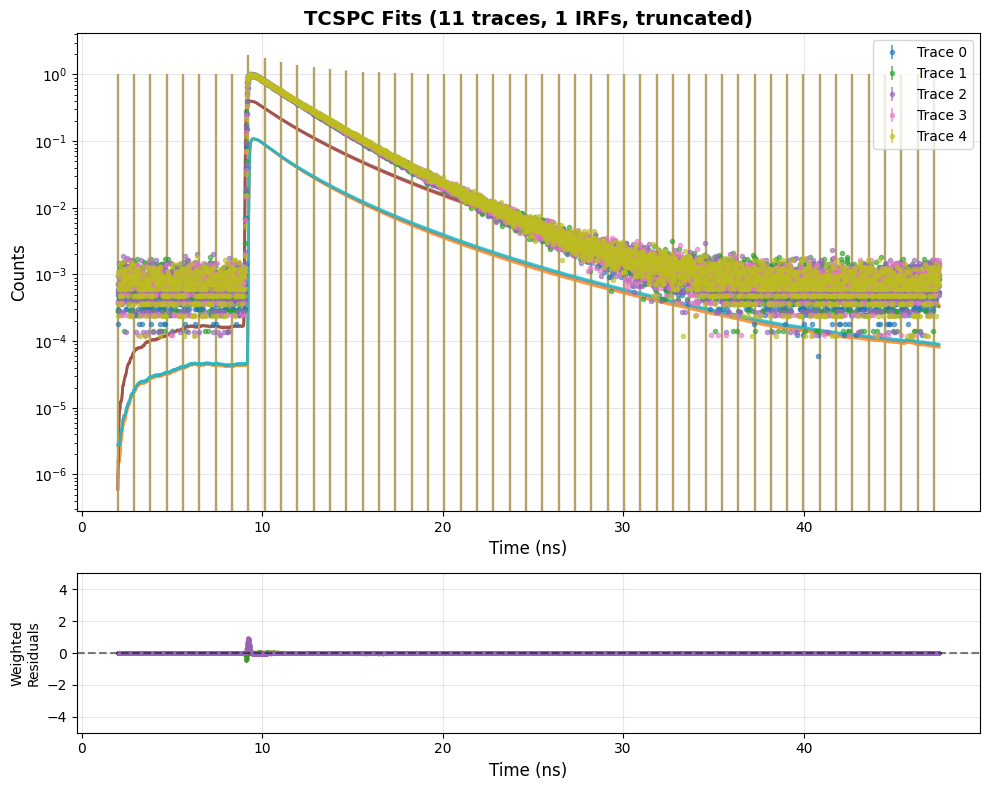

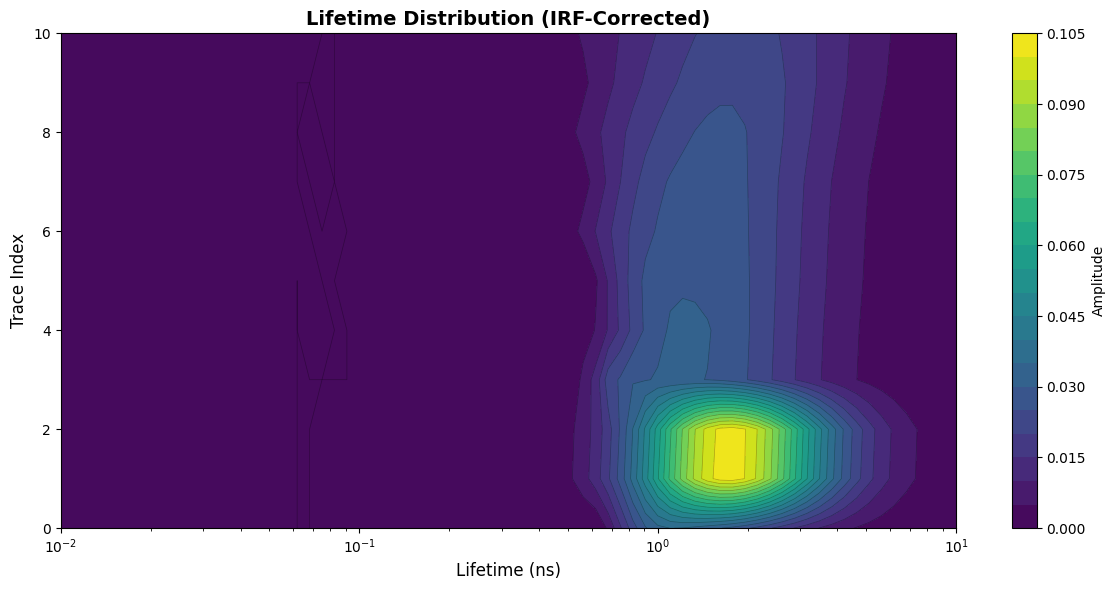

   Creating convergence plot...


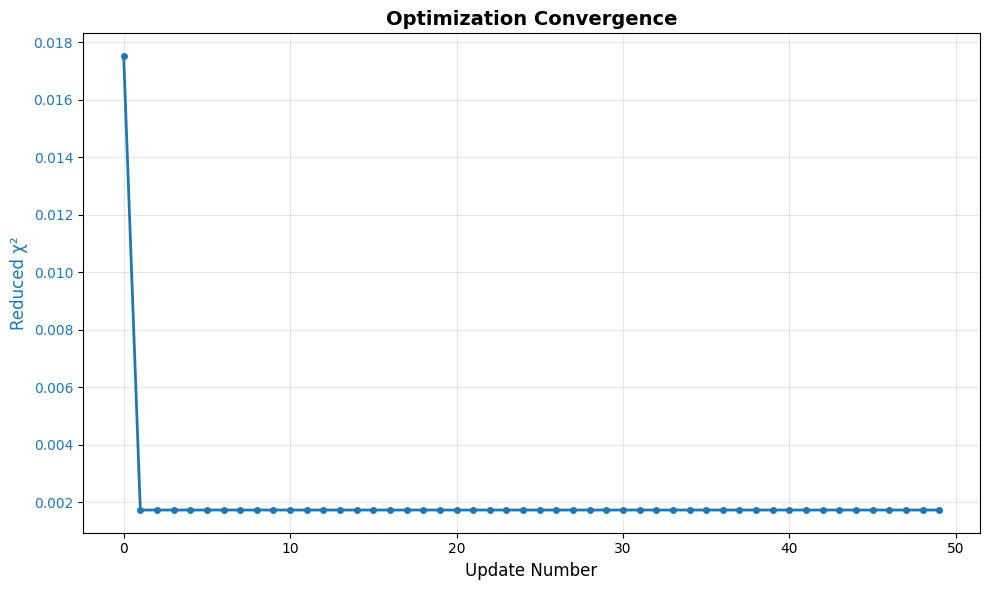

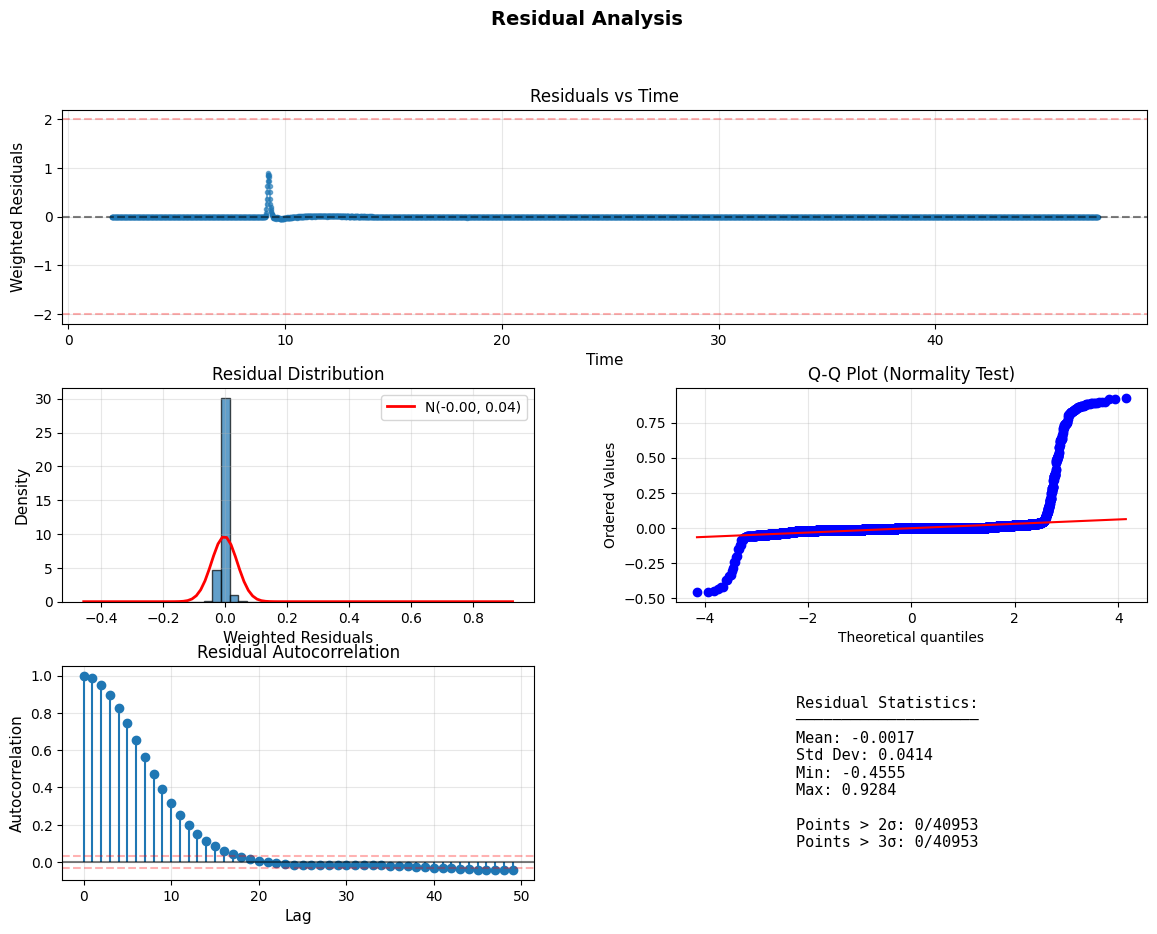


   All plots displayed. Close plot windows to continue or use plt.show() to keep them open.


In [157]:
# STEP 10: VISUALIZE RESULTS

show_plots = True
save_plots = False

plotter = InteractivePlotter()
all_figures = []

# Plot 1: Decay curves with fits
fig1 = plotter.plot_decay_curves(
    data_final, time, fits_matrix, residuals_matrix,
    std_matrix, log_scale=True,
    title=f"TCSPC Fits ({n_traces} traces, {n_irfs} IRFs, truncated)"
)
all_figures.append(fig1)
if save_plots:
  plt.figure(fig1.number)
  plt.savefig('tcspc_decay_fits.png', dpi=300, bbox_inches='tight')
  print("      Saved: tcspc_decay_fits.png")
if show_plots:
  plt.figure(fig1.number)
  plt.show(block=False)

# Plot 2: Lifetime distributions
fig2 = plotter.plot_distribution(
    params_matrix[:n_grid, :],
    grid,
    plot_type='line' if n_traces == 1 else 'contour',
    x_label='Lifetime (ns)',
    z_label='Amplitude',
    title='Lifetime Distribution (IRF-Corrected)',
    log_x=True
)
all_figures.append(fig2)
if save_plots:
    plt.figure(fig2.number)
    plt.savefig('tcspc_lifetime_distribution.png', dpi=300, bbox_inches='tight')
    print("      Saved: tcspc_lifetime_distribution.png")
if show_plots:
    plt.figure(fig2.number)
    plt.show(block=False)

# Plot 3: Convergence
print("   Creating convergence plot...")
fig3 = plotter.plot_convergence(solver.chi_history)
all_figures.append(fig3)
if save_plots:
    plt.figure(fig3.number)
    plt.savefig('tcspc_convergence.png', dpi=300, bbox_inches='tight')
    print("      Saved: tcspc_convergence.png")
if show_plots:
    plt.figure(fig3.number)
    plt.show(block=False)

# Plot 4: Residuals
fig4 = plotter.plot_residual_analysis(residuals_matrix, time)
all_figures.append(fig4)
if save_plots:
    plt.figure(fig4.number)
    plt.savefig('tcspc_residuals.png', dpi=300, bbox_inches='tight')
    print("      Saved: tcspc_residuals.png")
if show_plots:
    plt.figure(fig4.number)
    plt.show(block=False)

if show_plots:
    print("\n   All plots displayed. Close plot windows to continue or use plt.show() to keep them open.")
    plt.pause(0.1)  # Brief pause to ensure plots render

In [159]:
# =========================================================================
# STEP 11: REPORT RESULTS
# =========================================================================
print("\n" + "="*70)
print("ANALYSIS RESULTS")
print("="*70)

print(f"\nTruncation:")
print(f"  Original: {n_times_orig} points")
print(f"  Used: {n_times} points ({100*n_times/n_times_orig:.1f}%)")

print(f"\nLag Summary:")
print(f"  Mean: {np.mean(best_lags):.4f} ns")
print(f"  Std: {np.std(best_lags):.4f} ns")
print(f"  Range: [{np.min(best_lags):.4f}, {np.max(best_lags):.4f}] ns")

print(f"\nQuality Metrics:")
print(f"  Final reduced χ²: {solver.chi_history[-1]:.4f}")
print(f"  Effective free parameters: {setup['efp']:.1f}")

if solver.chi_history[-1] < 1.2:
    print("  ✓ Excellent fit")
elif solver.chi_history[-1] < 2.0:
    print("  ✓ Good fit")
else:
    print("  ⚠ Poor fit - consider adjusting parameters")

# Show lifetime results for first few traces
print(f"\nLifetime Analysis (first {min(15, n_traces)} traces):")
for trace_idx in range(min(15, n_traces)):
    print(f"\n--- Trace {trace_idx} (IRF {best_irf_indices[trace_idx]}, lag {best_lags[trace_idx]:.4f} ns) ---")

    lifetime_amps = params_matrix[:n_grid, trace_idx]

    threshold = 0.05 * np.max(lifetime_amps)
    significant_indices = np.where(lifetime_amps > threshold)[0]

    if len(significant_indices) > 0:
        print(f"Significant lifetimes:")
        for idx in significant_indices:
            print(f"  τ = {grid[idx]:.3f} ns, amplitude = {lifetime_amps[idx]:.4f}")

        total_amp = np.sum(lifetime_amps)
        if total_amp > 0:
            mean_lifetime = np.sum(lifetime_amps * grid) / total_amp
            print(f"Mean lifetime: {mean_lifetime:.3f} ns")
    else:
        print("  No significant components found")

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)

# =========================================================================
# RETURN RESULTS
# =========================================================================
results = {
    'data': data_final,
    'time': time,
    'fits': fits_matrix,
    'residuals': residuals_matrix,
    'params_matrix': params_matrix,
    'grid': grid,
    'irf_matrix': irf_matrix,
    'best_irf_indices': best_irf_indices,
    'best_lags': best_lags,
    'chi_squared_matrix': irf_results['chi_squared_matrix'],
    'alpha': optimal_alpha,
    'chi_squared': solver.chi_history[-1],
    'chi_history': np.array(solver.chi_history),
    'std_matrix': std_matrix,
    'n_times_original': n_times_orig,
    'n_times_used': n_times,
    'figures': all_figures  # All figure objects for user access
}

# Keep plots open if showing
if show_plots:
    print("\n   Plots are displayed. They will remain open.")
    print("   To keep them interactive, call: plt.show()")


ANALYSIS RESULTS

Truncation:
  Original: 4096 points
  Used: 3723 points (90.9%)

Lag Summary:
  Mean: -0.0496 ns
  Std: 0.0771 ns
  Range: [-0.0860, 0.1140] ns

Quality Metrics:
  Final reduced χ²: 0.0017
  Effective free parameters: 412.5
  ✓ Excellent fit

Lifetime Analysis (first 11 traces):

--- Trace 0 (IRF 0, lag -0.0860 ns) ---
Significant lifetimes:
  τ = 0.681 ns, amplitude = 0.0059
  τ = 0.750 ns, amplitude = 0.0144
  τ = 0.825 ns, amplitude = 0.0228
  τ = 0.909 ns, amplitude = 0.0295
  τ = 1.000 ns, amplitude = 0.0336
  τ = 1.101 ns, amplitude = 0.0351
  τ = 1.212 ns, amplitude = 0.0348
  τ = 1.334 ns, amplitude = 0.0335
  τ = 1.468 ns, amplitude = 0.0319
  τ = 1.616 ns, amplitude = 0.0303
  τ = 1.778 ns, amplitude = 0.0284
  τ = 1.957 ns, amplitude = 0.0262
  τ = 2.154 ns, amplitude = 0.0235
  τ = 2.371 ns, amplitude = 0.0205
  τ = 2.610 ns, amplitude = 0.0176
  τ = 2.873 ns, amplitude = 0.0148
  τ = 3.162 ns, amplitude = 0.0122
  τ = 3.481 ns, amplitude = 0.0099
  τ = 3